### To run the code, you should have the dataset in the same folder:
```bash
Sentiment Analysis
├── Turkish-Movie Dataset
│   ├── movie_outerN.txt
│   ├── movie_outerP.txt
│   ├── movie_testN.txt
|   └─────────────────
├── sentiment.ipynb
├── dataset.py
├── prepare.py
├── results.txt
└── README.md
```

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import tensorflow as tf  # pytorch for the model, tensorflow for tokenizer
import gensim
from dataset import Dataset

c:\Users\karab\Desktop\turkish-word-embeddings\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
torch.cuda.get_device_name(0)

1.13.1+cu117


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# read train and test csv
traindf = pd.read_csv("dataset1/train.csv")
testdf = pd.read_csv("dataset1/test.csv")

# get label
trainy = traindf['sentiment'].values
testy = testdf['sentiment'].values

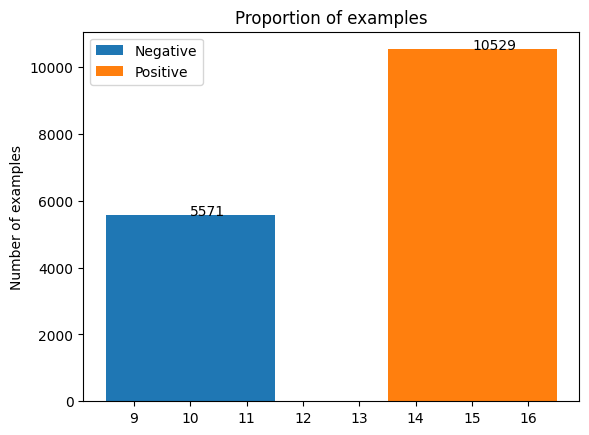

In [5]:
# visualize number of negatives and positive reviews
import matplotlib.pyplot as plt

negatives = traindf[traindf['sentiment'] == 0].shape[0]
positives = traindf[traindf['sentiment'] == 1].shape[0]

plt.bar(10, negatives, 3, label = 'Negative')
plt.bar(15, positives, 3, label = 'Positive')
# add numbers to the side of the bar
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.text(10, negatives, str(negatives))
plt.text(15, positives, str(positives))
plt.show()

In [6]:
# K-FOLD CROSS VALIDATION SETUP
kf = model_selection.StratifiedKFold(n_splits=5)

# assign folds to [0, 1, 2, 3, 4]
for fold, (train_, valid_) in enumerate(kf.split(X=traindf, y=trainy)):
    traindf.loc[valid_, 'kfold'] = fold

print("Total number of rows: ", traindf.shape[0])
print("Number of rows with kfold = 0", traindf[traindf.kfold==0].shape[0])
print("Number of rows with kfold = 1", traindf[traindf.kfold==1].shape[0])
print("Number of rows with kfold = 2", traindf[traindf.kfold==2].shape[0])
print("Number of rows with kfold = 3", traindf[traindf.kfold==3].shape[0])
print("Number of rows with kfold = 4", traindf[traindf.kfold==4].shape[0])

Total number of rows:  16100
Number of rows with kfold = 0 3220
Number of rows with kfold = 1 3220
Number of rows with kfold = 2 3220
Number of rows with kfold = 3 3220
Number of rows with kfold = 4 3220


In [7]:
MODEL = "C:/Users/karab/Desktop/Models/word2vec_10ep-300emb.bin"
MAX_LEN = 128 # maximum length for a sentence
DIM = 300
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5

In [8]:
#load fasttext embeddings
print('loading word embeddings...')
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
            MODEL,
            binary=False,
            no_header=False
        )

loading word embeddings...


KeyboardInterrupt: 

In [ ]:
print(len(word_vectors))
word_vectors["bilgisayar"].shape  # 300 dimensions

In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(LSTM, self).__init__()
        # Number of words = number of rows in embedding matrix
        num_words = embedding_matrix.shape[0]
        # Dimension of embedding is num of columns in the matrix
        embedding_dim = embedding_matrix.shape[1]
        # Define an input embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,
                                      embedding_dim=embedding_dim)
        # Embedding matrix actually is collection of parameter
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        # Because we use pretrained embedding (GLove, Fastext,etc) so we turn off requires_grad-meaning we do not train gradient on embedding weight
        self.embedding.weight.requires_grad = False
        # LSTM with hidden_size = 16
        self.lstm = nn.LSTM(
                            embedding_dim, 
                            16,
                            bidirectional=True,
                            batch_first=True,
                             )
        # Input(512) because we use bi-directional LSTM ==> hidden_size*2 + maxpooling **2  = 128*4 = 512, will be explained more on forward method
        self.out = nn.Linear(64, 1)
    def forward(self, x):
        # pass input (tokens) through embedding layer
        x = self.embedding(x)
        # fit embedding to LSTM
        hidden, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        # concat avg_pool and max_pool (so we have 256 size, also because this is bidirectional ==> 256*2 = 512)
        out = torch.cat((avg_pool, max_pool), 1)
        # fit out to self.out to conduct dimensionality reduction from 512 to 1
        out = self.out(out)
        # return output
        return out

In [ ]:
def train(data_loader, model, optimizer, device):
    """
    this is model training for one epoch
    data_loader:  this is torch dataloader, just like dataset but in torch and devide into batches
    model : lstm
    optimizer : torch optimizer : adam
    device:  cuda or cpu
    """
    # set model to training mode
    model.train()
    # go through batches of data in data loader
    for data in data_loader:
        reviews = data['review']
        targets = data['target']
        # move the data to device that we want to use
        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        # clear the gradient
        optimizer.zero_grad()
        # make prediction from model
        predictions = model(reviews)
        # caculate the losses
        loss = nn.BCEWithLogitsLoss()(predictions, targets.view(-1,1))
        # backprob
        loss.backward()
        #single optimization step
        optimizer.step()

In [ ]:
def evaluate(data_loader, model, device):
    final_predictions = []
    final_targets = []
    model.eval()
    # turn off gradient calculation
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            targets = data['target']
            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)
            # make prediction
            predictions = model(reviews)
            # move prediction and target to cpu
            predictions = predictions.cpu().numpy().tolist()
            targets = targets.cpu().numpy().tolist()
            # add predictions to final_prediction
            final_predictions.extend(predictions)
            final_targets.extend(targets)
    return final_predictions, final_targets

In [ ]:
def create_embedding_matrix(word_index, embedding_dict=None, dim=300):
    """
     this function create the embedding matrix save in numpy array
    :param word_index: a dictionary with word: index_value
    :param embedding_dict: a dict with word embedding
    :d_model: the dimension of word pretrained embedding
    :return a numpy array with embedding vectors for all known words
    """
    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

# embedding_dict['word'] = vector
# word_index['word'] = index
# embedding_matrix[index] = vector

In [ ]:
traindf['review'].values.tolist()[:5] # list of sentences

In [ ]:
# STEP 1: Tokenization
# use tf.keras for tokenization,  
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(traindf['review'].values.tolist())

In [ ]:
print('Load embeddings')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=word_vectors, dim=DIM)


for fold in range(5):
    # STEP 2: cross validation
    train_df = traindf[traindf.kfold != fold].reset_index(drop=True)
    valid_df = traindf[traindf.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = Dataset(reviews=xtrain, targets=train_df['sentiment'].values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = Dataset(reviews=xtest, targets=valid_df['sentiment'].values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model_fasttext = LSTM(embedding_matrix)
    # set model to cuda device
    model_fasttext.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=1e-3)
    
    print('training model')

    for epoch in tqdm(range(EPOCHS)):
        # train one epoch
        train(train_data_loader, model_fasttext, optimizer, device)
        # validate
        outputs, targets = evaluate(valid_data_loader, model_fasttext, device)
        # threshold
        outputs = np.array(outputs) >= 0.5
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

In [ ]:
# test on test set testdf and testy
xtest = tokenizer.texts_to_sequences(testdf.review.values)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
test_dataset = Dataset(reviews=xtest, targets=testy)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
outputs, targets = evaluate(test_data_loader, model_fasttext, device)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
print(f'accuracy_score: {accuracy}')

In [ ]:
import seaborn as sn
# In the confusion matrix, the rows represent the actual number of positive and negative documents in the test set, 
# whereas the columns represent what the model has predicted. 
cm = metrics.confusion_matrix(targets, outputs)
sn.heatmap(cm, annot=True, fmt = '.2f')

In [ ]:
from torchmetrics.classification import BinaryF1Score
metric = BinaryF1Score()
metric(torch.tensor(targets).reshape(-1, 1), torch.tensor(outputs).reshape(-1, 1))